# Importing Libraries

In [7]:
import gc
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from keras import layers
from keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from keras.models import Sequential

from keras import backend as K
from tensorflow.keras.applications import ResNet50, MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.compat.v1 import logging
logging.set_verbosity(logging.ERROR)

In [8]:
# Importing Data
data = pd.read_csv('../input/breakhis/Folds.csv')

# Image Directory
img_dir = '../input/breakhis/BreaKHis_v1/'

# Class Labels
class_names = ['benign', 'malignant']

# Data Pre-processing

In [9]:
# Renaming Column
if 'path' not in data.columns:
    data = data.rename(columns={'filename':'path'})

# Adding Columns with useful data
if 'label' or 'label_int' or 'filename' not in data.columns:
    data['label'] = data.path.apply(lambda x: x.split('/')[3])
    data['label_int'] = data.label.apply(lambda x: class_names.index(x))
    data['filename'] = data.path.apply(lambda x: x.split('/')[-1])

# Printing Useful information
print("Data Shape: ", data.shape)
print("Folds: ", data.fold.unique())
print("Magnifications: ", data.mag.unique())
print("Labels: ", data.label.unique(), data.label_int.unique())

print("Dataset:")
data.head(3)

Data Shape:  (39545, 7)
Folds:  [1 2 3 4 5]
Magnifications:  [100 200  40 400]
Labels:  ['benign' 'malignant'] [0 1]
Dataset:


,fold,mag,grp,path,label,label_int,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-003.png


### Visualizing Label Counts

Count of Benign    :  2480.0
Count of Malignant :  5429.0


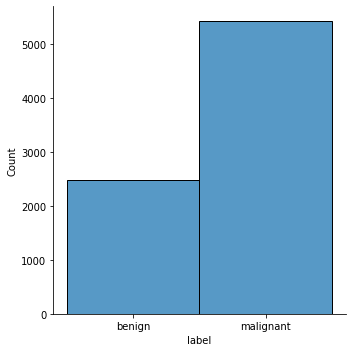

In [10]:
ax = sns.displot(data=data.iloc[0:7909], x='label')
print('Count of Benign    : ', data[data.label == 'benign'].label.count()/5)
print('Count of Malignant : ', data[data.label == 'malignant'].label.count()/5)

### Categorizing Data using Magnifications

Magnification: 100
malignant    1437.0
benign        644.0
Name: label, dtype: float64 

Magnification: 200
malignant    1390.0
benign        623.0
Name: label, dtype: float64 

Magnification: 40
malignant    1370.0
benign        625.0
Name: label, dtype: float64 

Magnification: 400
malignant    1232.0
benign        588.0
Name: label, dtype: float64 



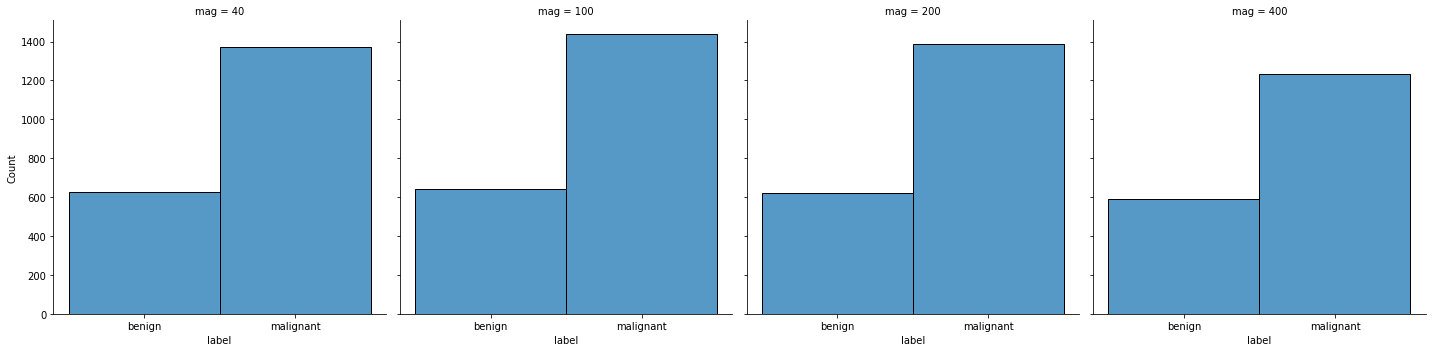

In [11]:
# Plotting Data for all magnifications
ax = sns.displot(data=data.iloc[0:7909], x='label', col='mag')

# Data Dict
data_dict = {}

# Categorizing for all mags
for mag in data['mag'].unique():
    data_dict[mag]=data.loc[data['mag'] == mag].copy()
    print('Magnification:', mag)
    print(data_dict[mag].label.value_counts()/5, "\n")

### Load and View Images

In [12]:
img_width = 224
img_height = 224
dim = (img_width, img_height)

# Iterating on Mags
for mag in data['mag'].unique():
    # Initializing images column
    data_dict[mag]['img_read'] = np.nan
    data_dict[mag]['img_read'] = data_dict[mag]['img_read'].astype(object)

    # Printing Info
    print("[INFO] Importing Images for Magnification",mag)

    # Iterating on all rows and reading image data
    for index, row in tqdm(data_dict[mag].iterrows(), total=data_dict[mag].shape[0]):
        img = cv2.imread(img_dir + row.path)
        if img.shape != (img_width, img_height, 3):
            img = cv2.resize(img, dim)
        data_dict[mag].at[index, 'img_read'] = img

[INFO] Importing Images for Magnification 100


100%|██████████| 10405/10405 [02:07<00:00, 81.45it/s]


[INFO] Importing Images for Magnification 200


100%|██████████| 10065/10065 [02:16<00:00, 73.52it/s]


[INFO] Importing Images for Magnification 40


100%|██████████| 9975/9975 [02:15<00:00, 73.39it/s] 


[INFO] Importing Images for Magnification 400


100%|██████████| 9100/9100 [02:04<00:00, 73.11it/s] 


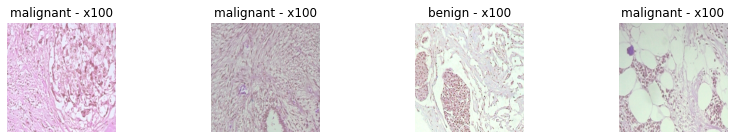

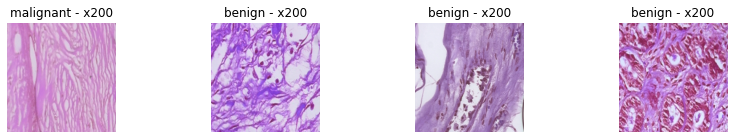

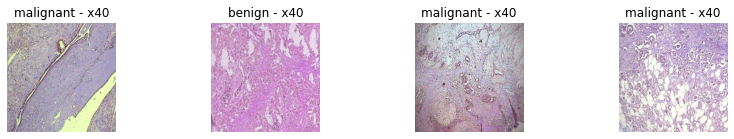

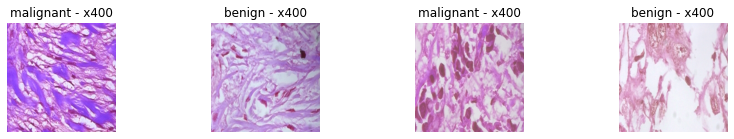

In [13]:
row = 1
col = 4
per_mag = 4

for mag in data['mag'].unique():
    fig, axes = plt.subplots(row, col, figsize=(3.5*col,2*row))
    for images, labels, i in zip(data_dict[mag].sample(per_mag).iloc[:, 7],
                                 data_dict[mag].sample(per_mag).iloc[:, 4],
                                 range(per_mag)):
        ax = axes[i]
        ax.imshow(images)
        ax.set_title(labels+" - x"+str(mag))
        ax.axis("off") 
    plt.show()

In [14]:
EPOCHS = 10
INIT_LR = 1e-4
BATCH_SIZE = 16
INPUT_SHAPE = (224,224,3)

In [15]:
def build_model(backbone, lr=INIT_LR):
    model = Sequential()
    model.add(backbone)
    model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
    model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
    model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=lr),
                  metrics=['accuracy'])
    
    return model

In [16]:
# Early stop to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [17]:
datagen = ImageDataGenerator(rescale=1 / 255.0,
                              rotation_range=20,
                              zoom_range=0.05,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.05,
                              horizontal_flip=True,
                              vertical_flip=True,
                              fill_mode="nearest")

In [18]:
def Train(mag, fold):
    # Train Data
    X_train = np.stack(data_dict[mag][(data_dict[mag]["fold"]==fold) & (data_dict[mag]["grp"]=="train")].img_read.to_list())
    y_train = data_dict[mag][(data_dict[mag]["fold"]==fold) & (data_dict[mag]["grp"]=="train")].label_int.to_list()
    y_train = to_categorical(y_train, num_classes= 2)

    # Test Data
    X_test = np.stack(data_dict[mag][(data_dict[mag]["fold"]==fold) & (data_dict[mag]["grp"]=="test")].img_read.to_list())
    y_test = data_dict[mag][(data_dict[mag]["fold"]==fold) & (data_dict[mag]["grp"]=="test")].label_int.to_list()

    # Validation Data
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=69)
    
    # Initializing Model
    K.clear_session()
    gc.collect()
    DenseNet201_model = DenseNet201(weights='imagenet',
                                    include_top=False,
                                    input_shape=INPUT_SHAPE)
    model = build_model(DenseNet201_model , lr = INIT_LR)
    
    print("--------------------------------------------------------------------------------------------")
    print("                               [INFO] Training Model")
    print("--------------------------------------------------------------------------------------------")
    
    # Fit Model
    history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                         steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
                         epochs= EPOCHS,
                         validation_data=(X_val/255, y_val),
                         callbacks=[early_stop],
                         verbose=1)
    
    print("--------------------------------------------------------------------------------------------")
    print("                               [INFO] Evaluating Model")
    print("--------------------------------------------------------------------------------------------")
    # Evaluate model
    model.evaluate(X_val/255, y_val)

    y_pred = model.predict(X_test/255)
    y_pred = np.argmax(y_pred,axis=1)
    
    return model, history, y_test, y_pred

In [19]:
def History_metrics(history):    
    sns.set()

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    #accuracy plot
    plt.plot(epochs, accuracy, color='b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, color='r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.figure()
    #loss plot
    plt.plot(epochs, loss, color='g', label='Training Loss')
    plt.plot(epochs, val_loss, color='y', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [20]:
def Model_report(y_test, y_pred):
    sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt='g')
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [21]:
mag_acc=np.empty((4,1))

# Magnification: 100x

In [45]:
mag =100

## Fold 4

In [69]:
m, history, y_test, y_pred = Train(mag, 4)

--------------------------------------------------------------------------------------------
                               [INFO] Training Model
--------------------------------------------------------------------------------------------
Epoch 1/10
59/59 [==============================] - 38s 324ms/step - loss: 0.7176 - accuracy: 0.6017 - val_loss: 0.6144 - val_accuracy: 0.6833
Epoch 2/10
59/59 [==============================] - 15s 247ms/step - loss: 0.5416 - accuracy: 0.7956 - val_loss: 0.5810 - val_accuracy: 0.6833
Epoch 3/10
59/59 [==============================] - 15s 250ms/step - loss: 0.4423 - accuracy: 0.8676 - val_loss: 0.5454 - val_accuracy: 0.6875
Epoch 4/10
59/59 [==============================] - 15s 241ms/step - loss: 0.3743 - accuracy: 0.8822 - val_loss: 0.4238 - val_accuracy: 0.7750
Epoch 5/10
59/59 [==============================] - 16s 271ms/step - loss: 0.3262 - accuracy: 0.9124 - val_loss: 0.3012 - val_accuracy: 0.8625
Epoch 6/10
59/59 [============================

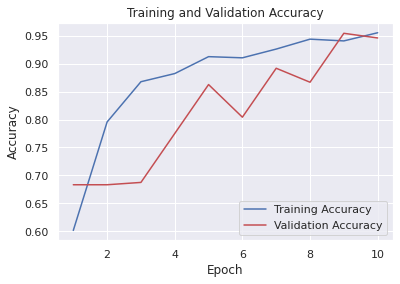

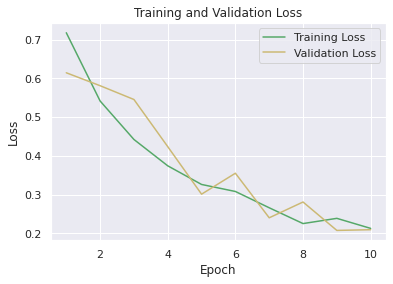

In [70]:
History_metrics(history)

              precision    recall  f1-score   support

           0       0.73      0.88      0.79       224
           1       0.92      0.81      0.86       397

    accuracy                           0.84       621
   macro avg       0.82      0.84      0.83       621
weighted avg       0.85      0.84      0.84       621



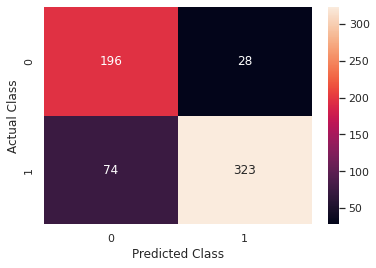

In [71]:
mag_acc[0] = Model_report(y_test, y_pred)

In [72]:
# Save the model to disk
#print("[INFO] Serializing network...")
#model100.save("models/trained_bin_100_1")

# Magnification: 200x

In [73]:
mag = 200

## Fold 4

In [74]:
m, history, y_test, y_pred = Train(mag, 4)

--------------------------------------------------------------------------------------------
                               [INFO] Training Model
--------------------------------------------------------------------------------------------
Epoch 1/10
66/66 [==============================] - 40s 311ms/step - loss: 0.7705 - accuracy: 0.5511 - val_loss: 0.6412 - val_accuracy: 0.6742
Epoch 2/10
66/66 [==============================] - 17s 251ms/step - loss: 0.5547 - accuracy: 0.7413 - val_loss: 0.5717 - val_accuracy: 0.7041
Epoch 3/10
66/66 [==============================] - 17s 258ms/step - loss: 0.4288 - accuracy: 0.8529 - val_loss: 0.3513 - val_accuracy: 0.8577
Epoch 4/10
66/66 [==============================] - 17s 252ms/step - loss: 0.3374 - accuracy: 0.8969 - val_loss: 0.3133 - val_accuracy: 0.8577
Epoch 5/10
66/66 [==============================] - 18s 262ms/step - loss: 0.2792 - accuracy: 0.9353 - val_loss: 0.1460 - val_accuracy: 0.9700
Epoch 6/10
66/66 [============================

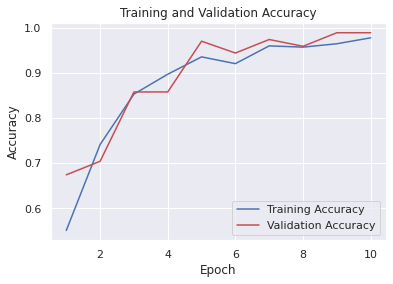

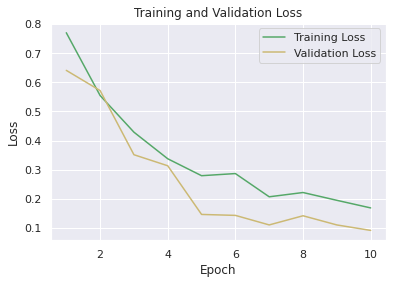

In [75]:
History_metrics(history)

              precision    recall  f1-score   support

           0       0.79      0.87      0.82       225
           1       0.93      0.88      0.91       454

    accuracy                           0.88       679
   macro avg       0.86      0.87      0.87       679
weighted avg       0.88      0.88      0.88       679



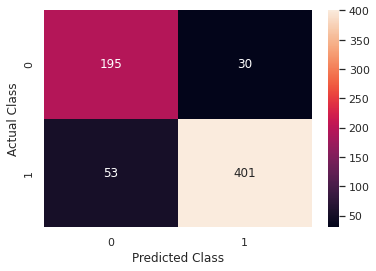

In [76]:
mag_acc[1] = Model_report(y_test, y_pred)

In [77]:
# Save the model to disk
#print("[INFO] Serializing network...")
#model200.save("models/trained_bin_200_1")

# Magnification: 40x

In [78]:
mag = 40

## Fold 4

In [79]:
m, history, y_test, y_pred = Train(mag, 4)

--------------------------------------------------------------------------------------------
                               [INFO] Training Model
--------------------------------------------------------------------------------------------
Epoch 1/10
64/64 [==============================] - 39s 316ms/step - loss: 0.6956 - accuracy: 0.6284 - val_loss: 0.6236 - val_accuracy: 0.6795
Epoch 2/10
64/64 [==============================] - 16s 248ms/step - loss: 0.4560 - accuracy: 0.8272 - val_loss: 0.5624 - val_accuracy: 0.7066
Epoch 3/10
64/64 [==============================] - 17s 260ms/step - loss: 0.3024 - accuracy: 0.9247 - val_loss: 0.5747 - val_accuracy: 0.7066
Epoch 4/10
64/64 [==============================] - 16s 243ms/step - loss: 0.2655 - accuracy: 0.9411 - val_loss: 0.4563 - val_accuracy: 0.7876
Epoch 5/10
64/64 [==============================] - 16s 252ms/step - loss: 0.2511 - accuracy: 0.9450 - val_loss: 0.2908 - val_accuracy: 0.8764
Epoch 6/10
64/64 [============================

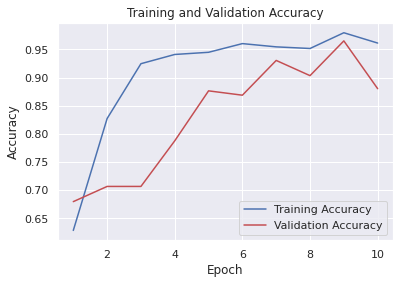

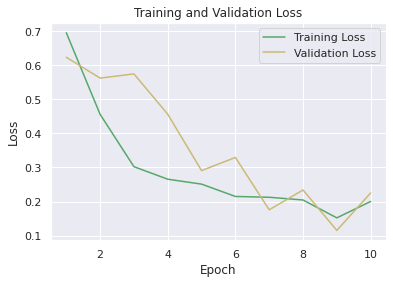

In [80]:
History_metrics(history)

              precision    recall  f1-score   support

           0       0.85      0.53      0.65       241
           1       0.79      0.95      0.86       459

    accuracy                           0.80       700
   macro avg       0.82      0.74      0.76       700
weighted avg       0.81      0.80      0.79       700



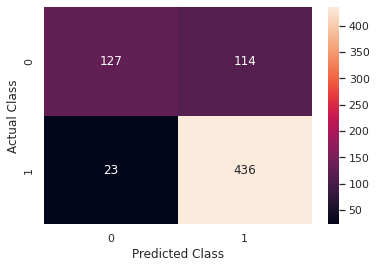

In [81]:
mag_acc[2] = Model_report(y_test, y_pred)

In [82]:
# Save the model to disk
#print("[INFO] Serializing network...")
#model40.save("models/trained_bin_40_1")

# Magnification: 400x

In [83]:
mag = 400

## Fold 4

In [84]:
m, history, y_test, y_pred = Train(mag, 4)

--------------------------------------------------------------------------------------------
                               [INFO] Training Model
--------------------------------------------------------------------------------------------
Epoch 1/10
59/59 [==============================] - 37s 302ms/step - loss: 0.6515 - accuracy: 0.6809 - val_loss: 0.5960 - val_accuracy: 0.6833
Epoch 2/10
59/59 [==============================] - 15s 254ms/step - loss: 0.4408 - accuracy: 0.8530 - val_loss: 0.6328 - val_accuracy: 0.6833
Epoch 3/10
59/59 [==============================] - 15s 252ms/step - loss: 0.3534 - accuracy: 0.9093 - val_loss: 0.5339 - val_accuracy: 0.7250
Epoch 4/10
59/59 [==============================] - 16s 256ms/step - loss: 0.3095 - accuracy: 0.9260 - val_loss: 0.4115 - val_accuracy: 0.8042
Epoch 5/10
59/59 [==============================] - 15s 241ms/step - loss: 0.2679 - accuracy: 0.9395 - val_loss: 0.2895 - val_accuracy: 0.8750
Epoch 6/10
59/59 [============================

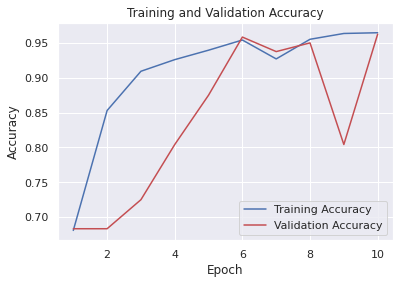

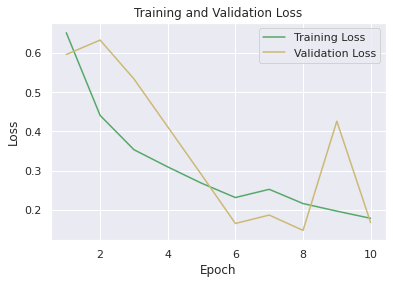

In [85]:
History_metrics(history)

              precision    recall  f1-score   support

           0       0.71      0.93      0.80       224
           1       0.95      0.78      0.86       397

    accuracy                           0.84       621
   macro avg       0.83      0.86      0.83       621
weighted avg       0.86      0.84      0.84       621



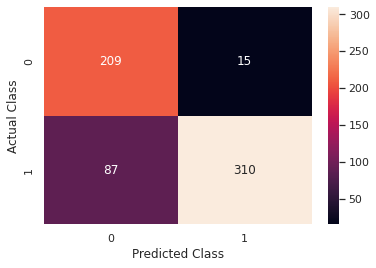

In [86]:
mag_acc[3] = Model_report(y_test, y_pred)

In [87]:
# Save the model to disk
#print("[INFO] Serializing network...")
#model400.save("models/trained_bin_400_1")